# TicTacToe

TicTacToe implemented with neural network based learning player.  

Random players can be used to generate CSV.  Learning player can use historical data for training.  

In [37]:
from tictactoe.game import Game, Board
from tictactoe.players import InputPlayer, RandomPlayer, LearningPlayer
from tictactoe.data import Storage, Stats
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
width = 3
height = 3
game = Game(width=width, height=height)

In [39]:
player1 = RandomPlayer()
player1a = RandomPlayer()

In [40]:
player2 = LearningPlayer()

Generates a random move from random player

In [41]:
player1.get_move(game.board)

(0, 0)

Create 5 games for random players to play

In [44]:
def play_game(game, player_x, player_o):
    game.player_x = player1
    game.player_o = player1a
    game.start()
    game.end()
    return (game.id, game.winner, Board.serialize(game.board))
    
rounds = [play_game(game, player1, player1a) for i in range(5)]
rounds

[('0x5ed2', None, 'XXOOOXXXO'),
 ('0xe0dd', 'X', 'OXXXXOXOO'),
 ('0x3cff', 'O', 'OOOXX-XOX'),
 ('0xe87', None, 'OXXXXOOOX'),
 ('0xf8e7', 'X', 'XOXOX-X-O')]

Retrieve historical game sessions

In [45]:
def load(src):
    df_s = pd.read_csv(src)
    df_s = df_s.fillna('NA')
    return df_s

In [46]:
df = load('data/0x7ac1.csv')
df = df.sort_values(by=['id'])
df.head()

,marker,move,board,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)",id,winner,empty_spaces
53310,O,"(2, 1)",OX--XO-OX,O,X,-,-,X,O,-,O,X,0x0,NA,0
53311,X,"(2, 0)",OXX-XO-OX,O,X,X,-,X,O,-,O,X,0x0,NA,0
53308,O,"(1, 2)",O---X--OX,O,-,-,-,X,-,-,O,X,0x0,NA,0
53313,X,"(0, 1)",OXXXXOOOX,O,X,X,X,X,O,O,O,X,0x0,NA,0
53307,X,"(1, 1)",O---X---X,O,-,-,-,X,-,-,-,X,0x0,NA,0


List winners by marker

In [1]:
def info(df_s):
    df_s = df_s.copy()
    df_s = df_s.groupby(['id', 'winner'], as_index=False).count()
    df_s['value'] = 1
    return df_s.groupby('winner')['value'].sum()

In [48]:
info(df)

winner
NA    1251
O     2779
X     5642
Name: value, dtype: int64

In [49]:
num_games = df.shape[0]
num_games

76094

Harmonize dataset to use learning values

In [50]:
def harmonize(df_s):
    df_x = df_s.copy()
    df_x = df_x.replace('X', 1.)
    df_x = df_x.replace('O', 0.)
    df_x = df_x.replace('-', 0.)
    df_x = df_x[df_x['winner'] != 'NA']
    df_x = df_x.rename({'winner': 'winner_x'}, axis=1)
    
    df_o = df_s.copy()
    df_o = df_o.replace('X', 0.)
    df_o = df_o.replace('O', 1.)
    df_o = df_o.replace('-', 0.)
    df_o = df_o[df_o['winner'] != 'NA']
    df_o = df_o.rename({'winner': 'winner_o'}, axis=1)
    df_o = df_o.drop('empty_spaces', axis=1)
    
    return pd.concat([df_x, df_o], axis=1)


In [51]:
harmonized_df = harmonize(df)
harmonized_df.head() 

,marker,move,board,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)",...,"(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)",id,winner_o
69343,1.0,"(0, 2)",-O--X-XXO,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0x1,0
69342,0.0,"(2, 2)",-O--X--XO,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0x1,0
69346,0.0,"(0, 1)",-O-OX-XXO,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0x1,0
69347,1.0,"(2, 0)",-OXOX-XXO,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0x1,0
69339,1.0,"(1, 2)",-------X-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x1,0


In [52]:
harmonized_df.shape

(64745, 29)

In [53]:
train_df, test_df = train_test_split(harmonized_df, test_size=0.2)

In [54]:
train_df.head()

,marker,move,board,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)",...,"(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)",id,winner_o
50804,1.0,"(1, 2)",-------X-,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0xa053,0
758,0.0,"(2, 2)",OX-OOXXXO,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0x1dde,1
16990,1.0,"(2, 2)",X-O-----X,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0x9464,0
59108,0.0,"(0, 2)",X---OXO--,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0x5906,1
619,1.0,"(1, 1)",XOOXXXO--,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0xcf09,0


In [55]:
test_df.head()

,marker,move,board,"(0, 0)","(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)",...,"(0, 1)","(0, 2)","(1, 0)","(1, 1)","(1, 2)","(2, 0)","(2, 1)","(2, 2)",id,winner_o
56340,0.0,"(1, 1)",X--XOXOO-,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0xe736,1
51191,1.0,"(0, 2)",------X--,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x3774,0
39558,1.0,"(0, 1)",---X-----,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x354,0
7963,0.0,"(1, 1)",--XOO-X--,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0xc51e,1
23986,1.0,"(1, 2)",O-----XX-,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0x3207,1


In [82]:
b = [[123, 321], [456, 654]]
np.concatenate((b, b), axis=0)

array([[123, 321],
       [456, 654],
       [123, 321],
       [456, 654]])

Build inputs

In [56]:
def parse_input_x(df_s):
    df_s = df_s.copy()
    filter_cols = ('id', 'board', 'move', 'marker', 'winner_x', 'winner_o')
    for col in filter_cols:
        df_s = df_s.drop(col, axis=1)
    return np.array(df_s.values.T, dtype=np.float64)

In [73]:
train_x = parse_input_x(train_df)
train_x

[array([[0., 0., 1., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 1., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 1., 0.]]), array([[0., 0., 1., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 0., ..., 1., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 1., 0.]])]

In [58]:
def parse_output_y(df_s):
    return np.array([df_s['winner_x'].values], dtype=np.float64)


In [59]:
train_y = parse_output_y(train_df)
train_y

array([[1., 0., 1., ..., 1., 0., 1.]])

In [83]:
train_x.shape

(19, 51796)

In [61]:
train_y.shape

(1, 51796)

In [62]:
test_x = parse_input_x(test_df)
test_y = parse_output_y(test_df)


In [63]:
test_x.shape

(19, 12949)

In [64]:
test_y.shape

(1, 12949)

In [65]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [88]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [89]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [90]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)

    assert(AL.shape[1] == X.shape[1])
            
    return AL, caches

In [91]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    #     assert(cost.shape == ())
    
    return cost

In [92]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [93]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [94]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(
        dAL,
        current_cache,
        'sigmoid'
    )
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(L-1)], current_cache, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [95]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

In [96]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


In [97]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0090, num_iterations = 2500, print_cost=False, print_freq=100):#lr was 0.009
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
        
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the cost every 100 training example
        if print_cost and i % print_freq == 0:
            print ("iteration: %i learning_rate: %f cost: %f" %(i, learning_rate, cost))
        if print_cost and i % print_freq == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [98]:
train_x.shape

(20, 51796)

In [99]:
layers_dims = (train_x.shape[0], 64, 9, 3, train_y.shape[0])
layers_dims

(20, 64, 9, 3, 1)

iteration: 0 learning_rate: 0.075000 cost: 0.972077
iteration: 100 learning_rate: 0.075000 cost: 0.603626
iteration: 200 learning_rate: 0.075000 cost: 0.543483
iteration: 300 learning_rate: 0.075000 cost: 0.475691
iteration: 400 learning_rate: 0.075000 cost: 0.404209
iteration: 500 learning_rate: 0.075000 cost: 0.362620
iteration: 600 learning_rate: 0.075000 cost: 0.291361
iteration: 700 learning_rate: 0.075000 cost: 0.232906
iteration: 800 learning_rate: 0.075000 cost: 0.199974
iteration: 900 learning_rate: 0.075000 cost: 0.171868
iteration: 1000 learning_rate: 0.075000 cost: 0.146591
iteration: 1100 learning_rate: 0.075000 cost: 0.120415
iteration: 1200 learning_rate: 0.075000 cost: 0.096512
iteration: 1300 learning_rate: 0.075000 cost: 0.079958
iteration: 1400 learning_rate: 0.075000 cost: 0.065195
iteration: 1500 learning_rate: 0.075000 cost: 0.051995
iteration: 1600 learning_rate: 0.075000 cost: 0.041160
iteration: 1700 learning_rate: 0.075000 cost: 0.033256
iteration: 1800 learni

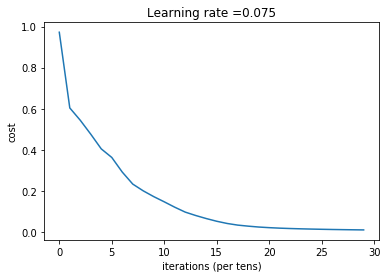

In [101]:
parameters = L_layer_model(train_x, train_y, layers_dims, 
                           learning_rate = 0.075, 
                           num_iterations = 3000, 
                           print_cost=True, 
                           print_freq=100)

In [102]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)
    
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
    
    return probas


In [103]:
pred_train = predict(train_x, train_y, parameters)
pd.DataFrame(pred_train).T.head()

Accuracy: 1.0000000000000002


,0
0,1.000000
1,0.000059
2,0.000390
3,1.000000
4,0.000407


In [104]:
pd.DataFrame(train_y).T.head()

,0
0,1.0
1,0.0
2,0.0
3,1.0
4,0.0


In [105]:
pred_test = predict(test_x, test_y, parameters)
pd.DataFrame(pred_test).T.head()

Accuracy: 1.0


,0
0,0.998110
1,0.000112
2,1.000000
3,0.994740
4,0.000126


In [106]:
pd.DataFrame(test_y).T.head()

,0
0,1.0
1,0.0
2,1.0
3,1.0
4,0.0
